In [54]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import
from future import standard_library
standard_library.install_aliases()  # NOQA
import argparse
import logging
import sys
#import box2d
from logging import getLogger
import chainer
from chainer import optimizers
import gym
gym.undo_logger_setup()  # NOQA
from gym import spaces
import gym.wrappers
import numpy as np
from matplotlib import style

import argparse
import logging


import matplotlib.pyplot as plt


from chainer import functions as F
from chainerrl.agents.trpo import TRPO
from chainerrl.agents.acer import ACERSeparateModel
from chainerrl.optimizers.nonbias_weight_decay import NonbiasWeightDecay
from chainerrl.optimizers import rmsprop_async
from chainerrl.action_value import QuadraticActionValue #Q-function output for continuous action space
#from chainerrl.action_value import DiscreteActionValue
import chainerrl
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import misc
from chainerrl import policy
from chainerrl import q_functions
from chainerrl import replay_buffer
from chainerrl import v_functions
#import osim
#from osim.env import L2RunEnv
style.use('ggplot')

/home/waleed_daud_wd/CondaEnvs/opensimEnv_V2/lib/python3.6/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


In [55]:
# environment settings

env_name='BipedalWalker-v2'

In [56]:
# Chainer's settings
parser = argparse.ArgumentParser()
#logging.basicConfig(level=args.logger_level)
seed=0
gpu=-1

In [57]:
number_of_episodes=10000
max_episode_length=500

replay_start_size=5000
number_of_update_times=1

target_update_interval=1
target_update_method='soft'

soft_update_tau=1e-2
update_interval=4
number_of_eval_runs=100
eval_interval=10 ** 5

final_exploration_steps=10 ** 6

gamma=0.995
minibatch_size=128


In [58]:
# Helper's functions

def clip_action_filter(a):
    return np.clip(a, action_space.low, action_space.high)

def reward_filter(r):
    return r 


def phi(obs):
    return obs.astype(np.float32)

def random_action():
    a = action_space.sample()
    if isinstance(a, np.ndarray):
        a = a.astype(np.float32)
    return a


def make_env(test,env_name,render=True):
    env = gym.make(env_name)
    # Use different random seeds for train and test envs
    env_seed = 2 ** 32 - 1 - seed if test else seed
    env.seed(env_seed)
    #if args.monitor:
        #env = gym.wrappers.Monitor(env, args.outdir)
    if isinstance(env.action_space, spaces.Box):
        misc.env_modifiers.make_action_filtered(env, clip_action_filter)
    if not test:
        misc.env_modifiers.make_reward_filtered(env, reward_filter)
    if render and not test:
        misc.env_modifiers.make_rendered(env)
    return env

In [59]:
# Set a random seed used in ChainerRL
misc.set_random_seed(seed)

In [60]:
#env = gym.make(env_name)
env = make_env(test=False,env_name=env_name,render=False)
#timestep_limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
#timestep_limit=300
obs_size = np.asarray(env.observation_space.shape).prod()
action_space = env.action_space

action_size = np.asarray(action_space.shape).prod()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [61]:
""""
q_func = q_functions.FCSAQFunction(
            obs_size, 
            action_size,
            n_hidden_channels=critic_hidden_units,
            n_hidden_layers=critic_hidden_layers)
"""
obs_space = env.observation_space
v_fuc = chainerrl.v_functions.FCVFunction(
        obs_space.low.size,
        n_hidden_channels=64,
        n_hidden_layers=4,
        last_wscale=0.01,
        nonlinearity=F.tanh,
)


v_fuc_opt = chainer.optimizers.Adam()
v_fuc_opt.setup(v_fuc)


pi =  chainerrl.policies.FCGaussianPolicyWithStateIndependentCovariance(
                obs_space.low.size,
                action_space.low.size,
                n_hidden_channels=64,
                n_hidden_layers=4,
                mean_wscale=0.01,
                nonlinearity=F.tanh,
                var_type='diagonal',
                var_func=lambda x: F.exp(2 * x),  # Parameterize log std
                var_param_init=0,  # log std = 0 => std = 1
)

In [62]:
#model
#rbuf = replay_buffer.ReplayBuffer(5 * 10 ** 5)

rbuf = replay_buffer.ReplayBuffer(5 * 10)

ou_sigma = (action_space.high - action_space.low) * 0.2

explorer = explorers.AdditiveOU(sigma=ou_sigma)
obs_normalizer = chainerrl.links.EmpiricalNormalization(obs_space.low.size)

#vf_opt = chainer.optimizers.Adam()
#vf_opt.setup(vf)

In [63]:
# The agent
agent = TRPO(
            policy=pi,
                 vf=v_fuc,
                 vf_optimizer = v_fuc_opt,
                 obs_normalizer=obs_normalizer,
                phi=lambda x: np.array(x).astype(np.float32, copy=False),
                update_interval=5000,
                conjugate_gradient_max_iter=20,
                conjugate_gradient_damping=1e-1,
                gamma=0.99,
                lambd=0.97,
                vf_epochs=5,
                entropy_coef=0,
            )


In [ ]:
G=[]
G_mean=[]
for ep in range(1, number_of_episodes+ 1):
    if ep%100:
        agent.save("TRPO_Walker2D_10000_v1")
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    episode_rewards=[]
    while not done and t < max_episode_length:
        # Uncomment to watch the behaviour
        #env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        episode_rewards.append(reward)
        t += 1
        
    if done or t >= max_episode_length :
            
            # Calculate sum of the rewards
        episode_rewards_sum = sum(episode_rewards)     
        G.append(episode_rewards_sum)
        total_G = np.sum(G)
        maximumReturn = np.amax(G)
        print("%f" % (episode_rewards_sum), file=open("TRPO_Walker2D_reward_10000_v1.txt", "a"))
        #print("%i" % (episode_rewards_sum))
        if ep % 10 == 0:
                
            print("==========================================")
            print("Episode: ", ep)
            print("Rewards: ", episode_rewards_sum)
            print("Max reward so far: ", maximumReturn)
            # Mean reward
            total_reward_mean = np.divide(total_G, ep+1)
            G_mean.append(total_reward_mean)
            print("Mean Reward", total_reward_mean)
            print("%f" % (total_reward_mean), file=open("TRPO_Walker2D_MEAN_Reward_10000_v1.txt", "a"))    
                
    agent.stop_episode_and_train(obs, reward, done)
    
    
print('Finished.')

plt.xlabel('episdes')
plt.ylabel('reword')
plt.title('trpo_Walker2D')    
plt.plot(G)   
plt.savefig('trpo_Walker2D_10000episodes_v1.png',dpi=1000)


plt.plot(G_mean)
plt.ylabel('Average of Returns trpo_Walker2D')
plt.xlabel('Number of episodes/10')
plt.title('ReturnsAverage_VS_Episodes trpo_Walker2D')
plt.savefig("ReturnsAverage_VS_Episodes trpo_Walker2D_10000_v1",dpi=1000)

Episode:  10
Rewards:  -38.972749966022285
Max reward so far:  -28.676405336924244
Mean Reward -62.814943782529504
Episode:  20
Rewards:  -107.50923551115456
Max reward so far:  -28.676405336924244
Mean Reward -77.0341252119666
Episode:  30
Rewards:  -33.06000829998402
Max reward so far:  -28.676405336924244
Mean Reward -85.65900938397876
Episode:  40
Rewards:  -40.573122385413704
Max reward so far:  -23.996195491336287
Mean Reward -76.33992688061035
Episode:  50
Rewards:  -34.73176915625824
Max reward so far:  -23.996195491336287
Mean Reward -76.32224383257733
Episode:  60
Rewards:  -34.260269283221405
Max reward so far:  -23.996195491336287
Mean Reward -75.85731839331515
Episode:  70
Rewards:  -107.30617596328817
Max reward so far:  -23.996195491336287
Mean Reward -77.73611052111808
Episode:  80
Rewards:  -34.366191172231616
Max reward so far:  -23.996195491336287
Mean Reward -77.6578997457835
Episode:  90
Rewards:  -111.7391508444293
Max reward so far:  -23.996195491336287
Mean Rewa

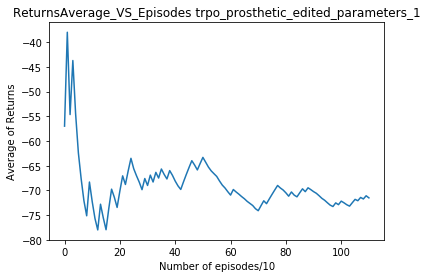

In [22]:
plt.plot(G_mean)
plt.ylabel('Average of Returns')
plt.xlabel('Number of episodes/10')
plt.title('ReturnsAverage_VS_Episodes trpo_prosthetic_edited_parameters_1')
plt.savefig("ReturnsAverage_VS_Episodes trpo_prosthetic_edited_parameters_1")

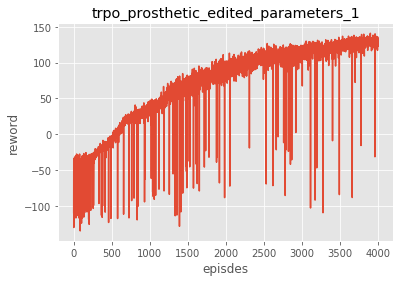

In [29]:
plt.xlabel('episdes')
plt.ylabel('reword')
plt.title('trpo_prosthetic_edited_parameters_1')    
plt.plot(G)   
plt.savefig('trpo_prosthetic_edited_parameters_1.png',dpi=1000)


NameError: name 'G' is not defined

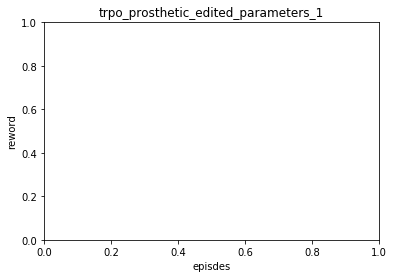

In [3]:

plt.xlabel('episdes')
plt.ylabel('reword')
plt.title('trpo_prosthetic_edited_parameters_1')    
plt.plot(G)   
plt.savefig('trpo_prosthetic_edited_parameters_1.png')

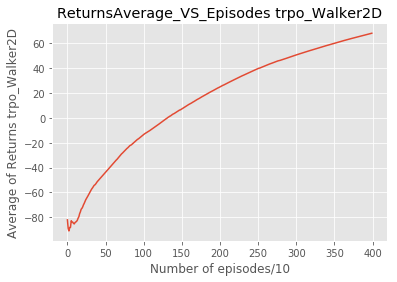

In [28]:
plt.plot(G_mean)
plt.ylabel('Average of Returns trpo_Walker2D')
plt.xlabel('Number of episodes/10')
plt.title('ReturnsAverage_VS_Episodes trpo_Walker2D')
plt.savefig("ReturnsAverage_VS_Episodes trpo_Walker2D_2_4000",dpi=1000)